In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path
import datetime
from shapely.ops import unary_union

from aimlsse_api.data.metar import *

In [2]:
target_states = ['California', 'Montana', 'Washington', 'Florida', 'Texas']

In [3]:
make_distribution_uniform = False
remove_ambiguous_cloud_cover = False
max_abs_timedelta_minutes = 30.0
image_size = 300 # Image side length in pixels
station_radius_of_influence = 16000.0 # meters

In [4]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

In [5]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, f'dataset_16km_{image_size}_ndsi')
if remove_ambiguous_cloud_cover:
    dataset_dir += '_unambiguous_cc'
if make_distribution_uniform:
    dataset_dir += '_sampled'
state_dirs = pd.DataFrame(pd.Series(target_states, name='state'))
state_dirs['target']    = state_dirs['state'].apply(lambda state: os.path.join(data_dir, 'queries', state))
state_dirs['features']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'features'))
state_dirs['preprocessing']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'preprocessing'))
state_dirs.set_index('state', inplace=True)
for dir in [data_dir, dataset_dir] + state_dirs['features'].to_list() \
        + state_dirs['preprocessing'].to_list():
    os.makedirs(dir, exist_ok=True)

In [6]:
state_dirs

,target,features,preprocessing
state,,,
California,data\queries\California,data\queries\California\features,data\queries\California\preprocessing
Montana,data\queries\Montana,data\queries\Montana\features,data\queries\Montana\preprocessing
Washington,data\queries\Washington,data\queries\Washington\features,data\queries\Washington\preprocessing
Florida,data\queries\Florida,data\queries\Florida\features,data\queries\Florida\preprocessing
Texas,data\queries\Texas,data\queries\Texas\features,data\queries\Texas\preprocessing


In [7]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [8]:
sentinel_products_metadata = pd.concat([
    pd.read_csv(os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv'), index_col=0) for preprocessing_dir in state_dirs['preprocessing']
])
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')

Found metadata for 15608 sentinel products


In [9]:
labels = pd.concat([pd.read_csv(os.path.join(state_dirs.loc[state, 'preprocessing'], 'labels.csv')) for state in target_states], ignore_index=True)
labels

,Unnamed: 0,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,0,BIH,00065e39-660f-4b17-a4ff-d528b87cef65,8.149600,CLR,CLR
1,1,MMH,00065e39-660f-4b17-a4ff-d528b87cef65,7.149600,CLR,CLR
2,2,JAQ,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
3,3,MCC,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
4,4,MHR,004885ef-ae75-4aca-917a-4218687d4536,5.682933,CLR,CLR
...,...,...,...,...,...,...
12744,4843,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,FEW
12745,4844,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,FEW
12746,4845,ORG,ffd7c508-0a7d-4185-9ce8-511fc421d012,4.149600,SCT,BKN
12747,4846,11R,fff52610-ce95-4c6b-9ebc-5d6912f0ff3d,8.316267,OVC,BKN


In [10]:
products = pd.Series(labels['product_id'].unique())
products

0       00065e39-660f-4b17-a4ff-d528b87cef65
1       004885ef-ae75-4aca-917a-4218687d4536
2       007321d3-330d-4dcf-9584-f9dc1190b4d7
3       00cb0f2f-92d9-4544-8be8-ec1ba851a7d4
4       00f56041-00bc-416f-9dac-4f3e504fe081
                        ...                 
6570    ffc6975c-dafc-4219-983a-e181e6d07e32
6571    ffd2f23c-d37f-406f-a730-2e7597690168
6572    ffd5bab3-4250-44ef-837f-04e213a66586
6573    ffd7c508-0a7d-4185-9ce8-511fc421d012
6574    fff52610-ce95-4c6b-9ebc-5d6912f0ff3d
Length: 6575, dtype: object

In [11]:
stations = pd.Series(labels['station'].unique())
stations

0      BIH
1      MMH
2      JAQ
3      MCC
4      MHR
      ... 
320    PSN
321    TYR
322    ILE
323    SNK
324    MKN
Length: 325, dtype: object

In [12]:
sentinel_products_metadata = sentinel_products_metadata.loc[products]

In [13]:
station_metadata = []
for state in target_states:
    tmp_station_metadata = pd.read_csv(os.path.join(state_dirs.loc[state, 'preprocessing'], 'station_metadata.csv'), index_col='id')
    tmp_station_metadata['state'] = state
    station_metadata += [tmp_station_metadata]
station_metadata = pd.concat(station_metadata)
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 15970 stations


In [14]:
station_metadata = station_metadata.loc[stations]

In [15]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region,state
id,,,,,,,,,,,,
BIH,POINT (-118.36361 37.37311),BIH,NaN,CA_ASOS,37.37311,-118.36361,1263.00000,USA,United States of America,North America,0.0,California
MMH,POINT (-118.83875 37.62406),MMH,NaN,CA_ASOS,37.62406,-118.83875,2173.00000,USA,United States of America,North America,0.0,California
JAQ,POINT (-120.79430 38.37420),JAQ,Jackson,CA_ASOS,38.37420,-120.79430,511.72168,USA,United States of America,North America,0.0,California
MCC,POINT (-121.40060 38.66700),MCC,Sacramento McClellan,CA_ASOS,38.66700,-121.40060,23.00000,USA,United States of America,North America,0.0,California
MHR,POINT (-121.29725 38.55526),MHR,NaN,CA_ASOS,38.55526,-121.29725,29.00000,USA,United States of America,North America,0.0,California
...,...,...,...,...,...,...,...,...,...,...,...,...
PSN,POINT (-95.70631 31.77969),PSN,NaN,TX_ASOS,31.77969,-95.70631,129.00000,USA,United States of America,North America,0.0,Texas
TYR,POINT (-95.40239 32.35414),TYR,NaN,TX_ASOS,32.35414,-95.40239,166.00000,USA,United States of America,North America,0.0,Texas
ILE,POINT (-97.68650 31.08583),ILE,NaN,TX_ASOS,31.08583,-97.68650,258.00000,USA,United States of America,North America,0.0,Texas


In [16]:
polygons: List[Polygon] = []
for geometry in usa_states.loc[target_states].geometry:
    if isinstance(geometry, MultiPolygon):
        polygons += list(geometry.geoms)
    elif isinstance(geometry, Polygon):
        polygons += [geometry]

<class 'shapely.geometry.multipolygon.MultiPolygon'>


<Axes: >

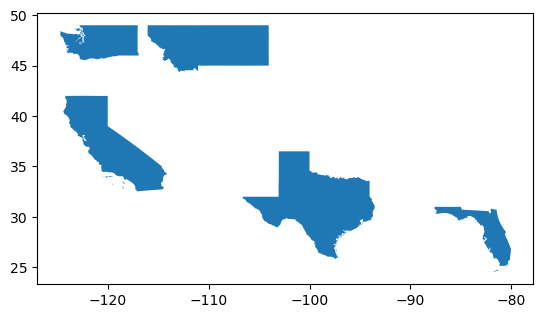

In [17]:
area_of_interest: MultiPolygon = unary_union(polygons)
print(type(area_of_interest))
gpd.GeoSeries(area_of_interest).plot()

In [18]:
def plot_state(ax:plt.Axes, state:str, color:str):
    gpd.GeoSeries(usa_states.loc[state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [19]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [20]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [21]:
remaining_stations_metadata = station_metadata

In [22]:
remaining_stations_metadata['geometry'] = remaining_stations_metadata['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
)

In [23]:
intersections: gpd.GeoDataFrame = remaining_stations_metadata[['geometry']].sjoin(remaining_stations_metadata[['geometry']], predicate="intersects")

In [24]:
intersections = intersections[intersections['index_right'] != intersections.index]

In [25]:
intersections = intersections.sample(frac=1, random_state=1)

In [26]:
intersections.head()

,geometry,index_right
id,,
CNO,"POLYGON ((-117.47916 33.84461, -117.47916 34.1...",ONT
SFF,"POLYGON ((-117.12203 47.54748, -117.12203 47.8...",SKA
EFD,"POLYGON ((-94.99482 29.46409, -94.99482 29.750...",LVJ
NUQ,"POLYGON ((-121.88812 37.27765, -121.88812 37.5...",PAO
SAT,"POLYGON ((-98.30712 29.39148, -98.30712 29.675...",RND


In [27]:
intersections_groups = intersections[['index_right']].groupby('index_right').groups
print(intersections_groups)

{'66R': ['ELA'], '9L2': ['EDW'], 'AFW': ['FTW', 'DTO', 'NFW', 'GPM', 'DFW', 'LUD'], 'AJO': ['SNA', 'CCB', 'POC', 'CNO', 'RAL', 'ONT'], 'APC': ['DVO', 'VCB', 'O69'], 'ARM': ['BYY'], 'ATT': ['T74', 'EDC', 'AUS'], 'AUN': ['LHM'], 'AUS': ['EDC', 'ATT'], 'AWO': ['PAE'], 'AXH': ['LVJ', 'HOU', 'EFD', 'SGR'], 'BAB': ['LHM', 'MYV'], 'BCT': ['LNA'], 'BFI': ['TIW', 'SEA', 'RNT'], 'BIF': ['ELP'], 'BKV': ['ZPH'], 'BPC': ['PPA'], 'BVS': ['NUW'], 'BYY': ['ARM'], 'CCB': ['RAL', 'ONT', 'CNO', 'POC', 'AJO'], 'CNO': ['RAL', 'CCB', 'POC', 'AJO', 'ONT'], 'COF': ['MLB', 'TIX', 'XMR'], 'CQT': ['SMO', 'LAX', 'TOA', 'HHR'], 'CRG': ['NRB', 'NIP', 'JAX'], 'CRP': ['NQI', 'RBO', 'NGP'], 'CRQ': ['NXF', 'OKB'], 'CWC': ['SPS'], 'CXO': ['DWH'], 'DED': ['SFB', 'OMN'], 'DFW': ['GPM', 'AFW', 'FTW', 'GKY'], 'DLF': ['T70'], 'DTO': ['AFW'], 'DTS': ['VPS', 'HRT'], 'DVO': ['O69', 'APC'], 'DWH': ['IAH', 'CXO'], 'EDC': ['T74', 'AUS', 'ATT'], 'EDW': ['9L2'], 'EFD': ['LVJ', 'HOU', 'AXH'], 'ELA': ['66R'], 'ELP': ['BIF'], 'EPH': ['

In [28]:
import networkx
import networkx.convert
graph = networkx.convert.from_dict_of_lists(intersections_groups)

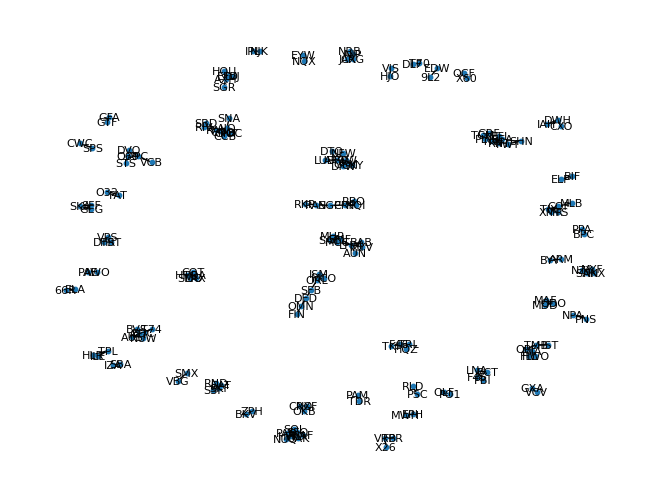

In [29]:
networkx.draw(graph, with_labels=True, font_size=8, node_size=10)

In [30]:
clusters = list(networkx.connected_components(graph))
print(clusters)
num_clusters = len(clusters)

[{'66R', 'ELA'}, {'9L2', 'EDW'}, {'FTW', 'GPM', 'LUD', 'NFW', 'DTO', 'AFW', 'DFW', 'GKY'}, {'SNA', 'RAL', 'RIV', 'CNO', 'AJO', 'POC', 'SBD', 'CCB', 'ONT'}, {'APC', 'O69', 'STS', 'DVO', 'VCB'}, {'BYY', 'ARM'}, {'ATT', 'T74', 'EDC', 'AUS'}, {'MYV', 'MCC', 'MHR', 'SAC', 'SMF', 'BAB', 'LHM', 'AUN'}, {'AWO', 'PAE'}, {'HOU', 'SGR', 'AXH', 'LVJ', 'EFD'}, {'F45', 'BCT', 'LNA', 'PBI'}, {'TCM', 'BFI', 'SEA', 'GRF', 'SHN', 'PWT', 'TIW', 'PLU', 'RNT'}, {'ELP', 'BIF'}, {'ZPH', 'BKV'}, {'BPC', 'PPA'}, {'NUW', 'BVS'}, {'TIX', 'XMR', 'MLB', 'TTS', 'COF'}, {'LAX', 'SMO', 'TOA', 'CQT', 'HHR'}, {'CRG', 'JAX', 'NIP', 'NRB'}, {'RKP', 'RAS', 'RBO', 'NGP', 'NQI', 'CRP'}, {'CRQ', 'NXF', 'OKB'}, {'SPS', 'CWC'}, {'DWH', 'CXO', 'IAH'}, {'SFB', 'DED', 'ISM', 'FIN', 'ORL', 'OMN', 'MCO'}, {'DLF', 'T70'}, {'VPS', 'HRT', 'DTS'}, {'MWH', 'EPH'}, {'EYW', 'NQX'}, {'HQZ', 'TKI', 'F46', 'TRL'}, {'FAT', 'O32'}, {'MIA', 'HWO', 'FLL', 'HST', 'OPF', 'TMB'}, {'X26', 'VRB', 'FPR'}, {'SFF', 'SKA', 'GEG'}, {'GTF', 'GFA'}, {'GXA',

In [31]:
def get_mapping_from_clusters(clusters:List[Set[str]]):
    mapping = {}
    current_cluster = 0
    for cluster in clusters:
        for node in cluster:
            mapping[node] = current_cluster
        current_cluster += 1
    return mapping

node_to_cluster_mapping = get_mapping_from_clusters(clusters)
print(node_to_cluster_mapping)

{'66R': 0, 'ELA': 0, '9L2': 1, 'EDW': 1, 'FTW': 2, 'GPM': 2, 'LUD': 2, 'NFW': 2, 'DTO': 2, 'AFW': 2, 'DFW': 2, 'GKY': 2, 'SNA': 3, 'RAL': 3, 'RIV': 3, 'CNO': 3, 'AJO': 3, 'POC': 3, 'SBD': 3, 'CCB': 3, 'ONT': 3, 'APC': 4, 'O69': 4, 'STS': 4, 'DVO': 4, 'VCB': 4, 'BYY': 5, 'ARM': 5, 'ATT': 6, 'T74': 6, 'EDC': 6, 'AUS': 6, 'MYV': 7, 'MCC': 7, 'MHR': 7, 'SAC': 7, 'SMF': 7, 'BAB': 7, 'LHM': 7, 'AUN': 7, 'AWO': 8, 'PAE': 8, 'HOU': 9, 'SGR': 9, 'AXH': 9, 'LVJ': 9, 'EFD': 9, 'F45': 10, 'BCT': 10, 'LNA': 10, 'PBI': 10, 'TCM': 11, 'BFI': 11, 'SEA': 11, 'GRF': 11, 'SHN': 11, 'PWT': 11, 'TIW': 11, 'PLU': 11, 'RNT': 11, 'ELP': 12, 'BIF': 12, 'ZPH': 13, 'BKV': 13, 'BPC': 14, 'PPA': 14, 'NUW': 15, 'BVS': 15, 'TIX': 16, 'XMR': 16, 'MLB': 16, 'TTS': 16, 'COF': 16, 'LAX': 17, 'SMO': 17, 'TOA': 17, 'CQT': 17, 'HHR': 17, 'CRG': 18, 'JAX': 18, 'NIP': 18, 'NRB': 18, 'RKP': 19, 'RAS': 19, 'RBO': 19, 'NGP': 19, 'NQI': 19, 'CRP': 19, 'CRQ': 20, 'NXF': 20, 'OKB': 20, 'SPS': 21, 'CWC': 21, 'DWH': 22, 'CXO': 22, '

In [32]:
clusted_stations = intersections.index.to_list()
print(clusted_stations)
remaining_stations_metadata['cluster'] = remaining_stations_metadata['name'].apply(
    lambda x: node_to_cluster_mapping[x] if x in clusted_stations else -1
)

['CNO', 'SFF', 'EFD', 'NUQ', 'SAT', 'PNS', 'RAL', 'RAL', 'CCB', 'HQZ', 'LNA', 'GPM', 'HLR', 'FLL', 'CRP', 'SAC', 'AXH', 'T74', 'MHR', 'SKA', 'BAB', 'O32', 'SFO', 'OPF', 'SMF', 'DWH', 'DTS', 'PWT', 'EPH', 'TRL', 'JAX', 'TMB', 'SNA', 'SKF', 'MIA', 'TIW', 'PSC', 'TDR', 'SAT', 'MYV', 'HWO', 'CCB', 'NUQ', 'SFO', 'HAF', 'RLD', 'SFO', 'NQI', 'GRF', 'RAL', 'POC', 'BKV', 'FTW', 'ODO', 'EDC', 'PLU', 'AFW', 'BAB', 'GKY', 'DED', 'SSF', 'BFI', '66R', 'SFB', 'GRF', 'SEA', 'XMR', 'MHR', 'DWH', 'CQT', 'FTW', 'IAH', 'VPS', 'AFW', 'CRQ', 'T70', 'LHM', 'ONT', 'AJO', 'F46', 'NRB', 'DVO', 'DTO', 'LVJ', 'RAL', 'LVJ', 'T74', 'AFW', 'IZA', 'TIW', 'POC', 'CWC', 'FLL', 'SAN', 'CNO', 'DFW', 'SBD', 'F45', 'NIP', 'ILE', 'HWD', 'TTS', 'HWD', 'HST', 'SQL', 'LNA', 'SPS', 'SFB', 'VCV', 'NUW', 'GPM', 'LVJ', 'ARM', 'SMO', 'SAC', 'FTW', 'MWH', 'POC', 'F46', 'ODO', 'MDD', 'NKX', 'BCT', 'DLF', 'CCB', 'LAX', 'HOU', 'TIW', 'GRF', 'HOU', 'NQI', 'AFW', 'AJO', 'FAT', 'PAO', 'MIA', 'MCC', 'VRB', 'OAK', 'APC', 'HAF', 'SMO', 'HWD'

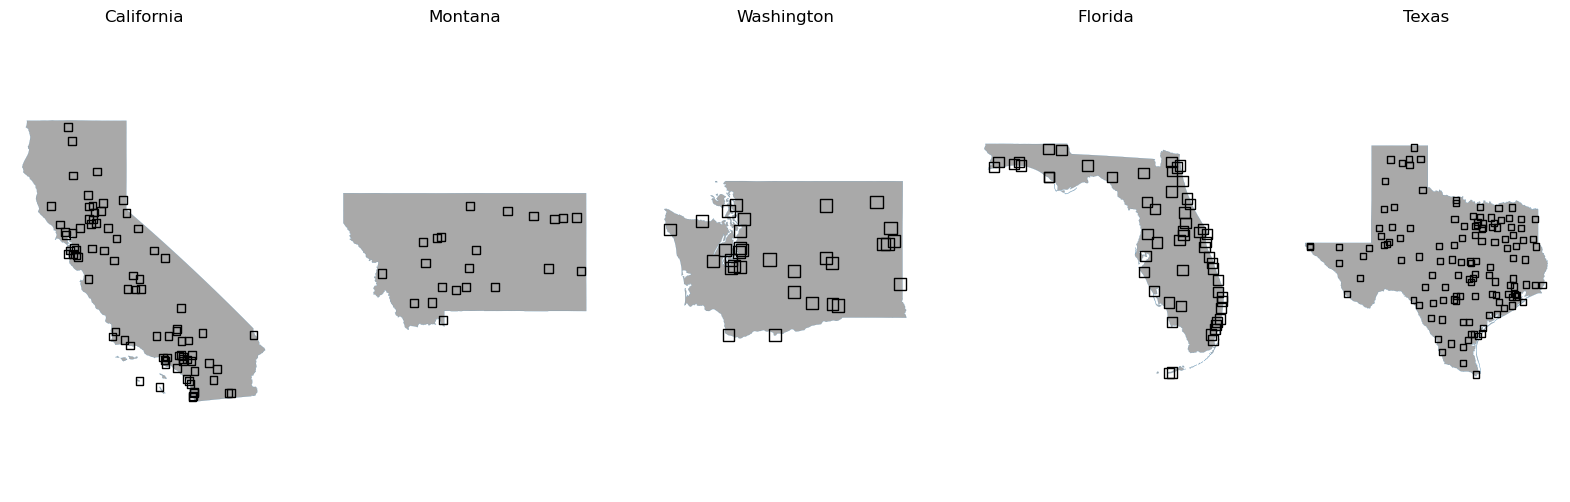

In [33]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[remaining_stations_metadata['state'] == state].plot(
        ax=ax, facecolor='none', edgecolor='black', legend=True
    )

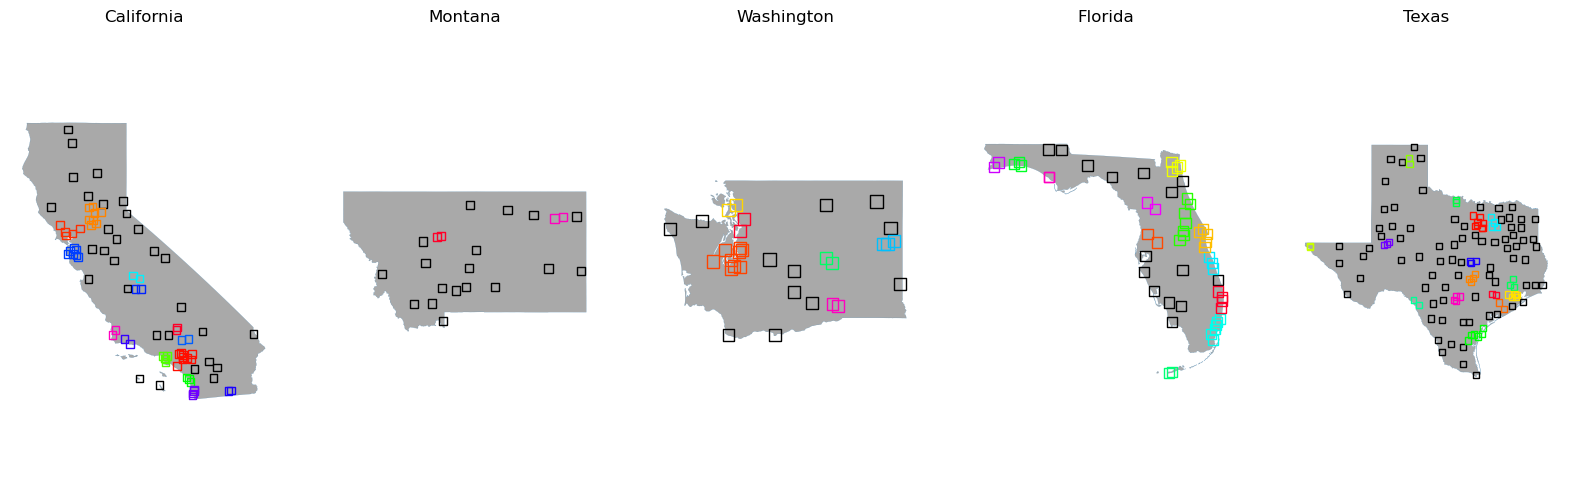

In [34]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] == -1)].plot(
        ax=ax, facecolor='none', edgecolor='black', legend=False
    )
    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].plot(
        column='cluster', ax=ax, facecolor='none', cmap='gist_rainbow', legend=False
    )

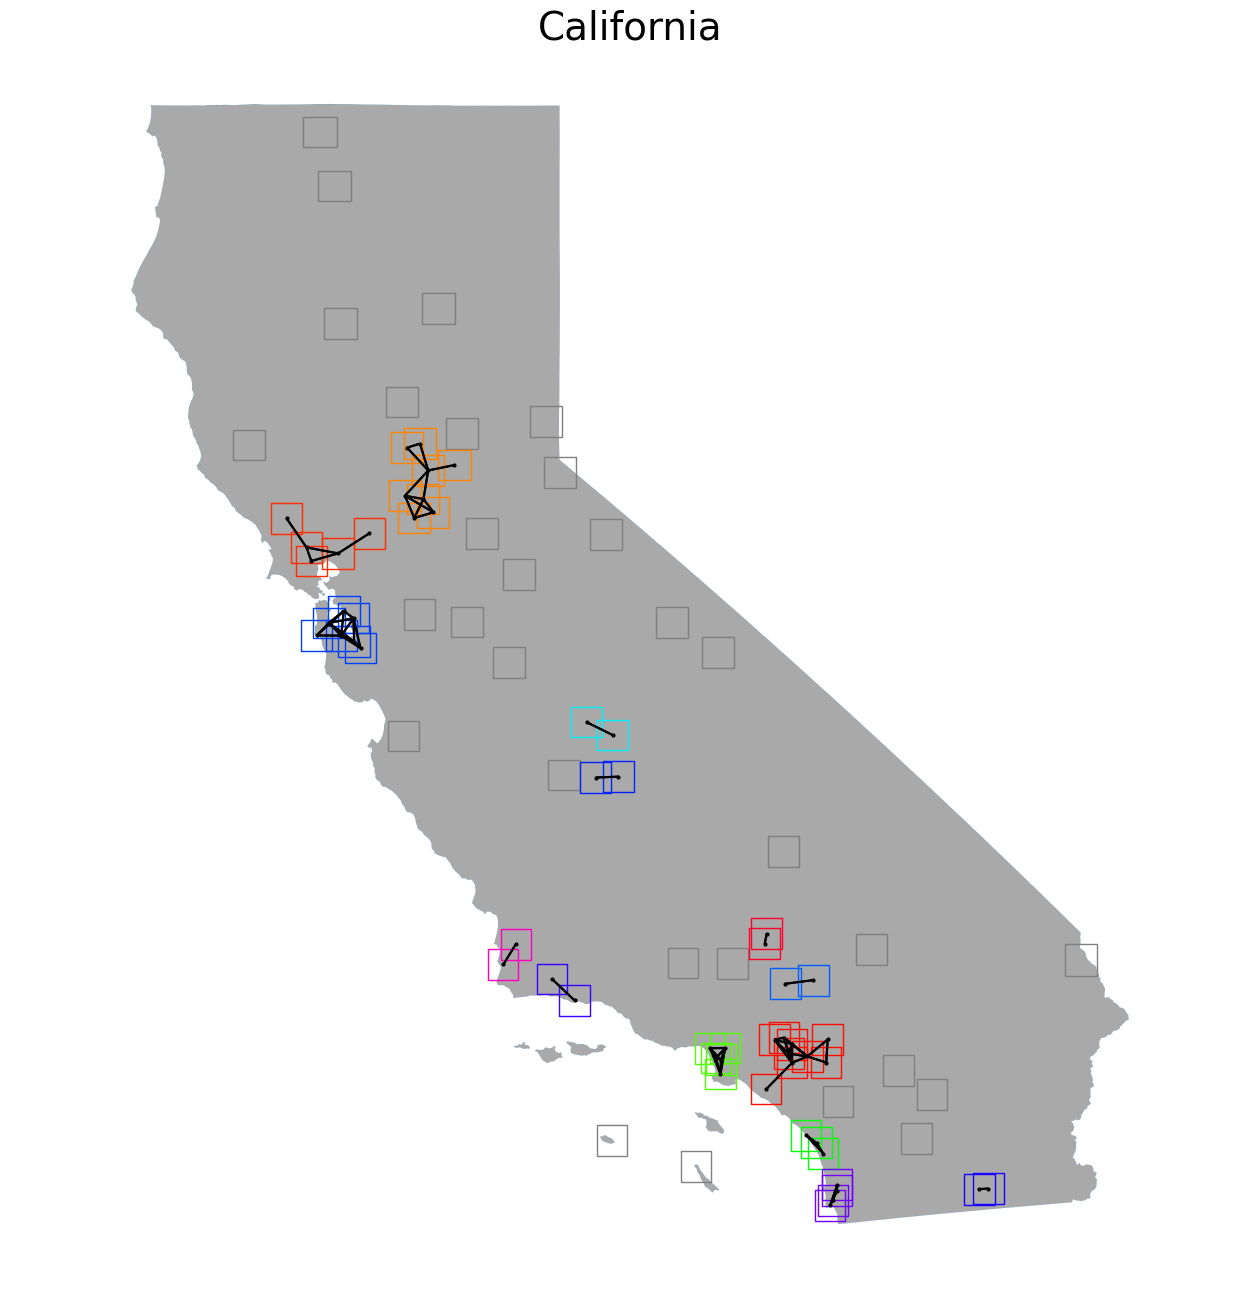

In [35]:
import warnings

fig, ax = plt.subplots(figsize=(16, 16))
if 'California' in target_states:
    state = 'California'
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state, fontsize=28)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] == -1)].plot(
        ax=ax, facecolor='none', edgecolor='gray', legend=False
    )

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].plot(
        column='cluster', ax=ax, facecolor='none', cmap='gist_rainbow', legend=False
    )

    for name, group in remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].groupby('cluster'):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            centroid_data = group.centroid
        current_intersections: Dict[str, pd.Index] = dict(filter(lambda x: x[0] in group.index.to_list(), intersections_groups.items()))
        lines = []
        for station in group.index:
            for other_station in current_intersections[station]:
                lines += [shapely.LineString([centroid_data.loc[station], centroid_data.loc[other_station]])]
                # if station in current_intersections[other_station]:
                #     current_intersections[other_station] = list(current_intersections[other_station]).remove(station)
                # if current_intersections[other_station] is None:
                #     current_intersections[other_station] = []
        gpd.GeoSeries(lines, crs=centroid_data.crs).plot(ax=ax, color='black')
        centroid_data.plot(ax=ax, color='black', markersize=4)
        

In [36]:
station_quantity = labels.groupby('station')['product_id'].count()
station_quantity

station
11R    24
1GM    23
1KM    54
1S5    67
28J    33
       ..
X26    33
X60    33
XMR    34
YKM    36
ZPH    35
Name: product_id, Length: 325, dtype: int64

In [37]:
@dataclass
class DatasetUnit:
    stations: Set[str]
    quantity: int

    def __lt__(self, other):
         return (self.quantity, self.stations) < (other.quantity, self.stations)

In [38]:
stations_not_in_cluster = set(remaining_stations_metadata['name']).difference(set.union(*clusters))
print(stations_not_in_cluster)

{'JAQ', 'LBB', 'MCE', 'O05', 'YKM', 'PSN', 'E38', 'ATA', 'SRQ', 'PYX', 'HLN', 'SLR', '63S', 'TRM', 'SGJ', 'HDO', 'JXI', 'BHK', 'MKN', 'BCR', 'EBG', 'BRO', 'UVA', 'SUA', 'CPT', 'MOD', 'FPY', 'NID', 'EED', 'LUV', 'HRF', 'TYR', 'SNK', '1GM', 'BMT', 'GDP', 'MCF', 'F17', 'VUO', 'SNS', 'F70', 'LWT', 'MHS', 'CZT', 'COM', '1KM', 'OVE', '6S0', 'BEA', 'TCY', 'CRS', 'INJ', 'PRS', 'GOO', 'COT', 'BZN', 'HRX', 'RSW', '28J', 'NLC', 'JSO', 'GNC', 'SEP', 'LLN', 'BGD', 'SMP', 'HBV', 'SJT', 'WJF', 'UIL', 'CDS', 'RBL', '8T6', 'OSA', 'SIY', 'LRD', 'LFK', 'MMH', 'PSP', 'DLN', 'NSI', 'T78', 'DEW', 'BBD', 'PUW', 'PRX', 'O22', 'GLS', 'INK', 'VHN', 'DKR', 'NUC', 'GVT', 'JDD', 'SEF', 'BKS', 'MWL', 'DLS', 'HVR', 'CLM', '4F2', 'E11', 'HHF', 'BPG', 'EKS', 'ECU', 'S85', '1S5', 'RFI', 'PEQ', 'GGW', 'WYS', 'UKI', 'ELN', 'PKV', '54A', 'DZB', 'APY', 'SDB', 'LZZ', 'F44', 'PSX', 'BIL', 'LCQ', 'LHB', 'DUX', 'OMK', 'ORG', 'TRK', 'TLH', '11R', 'IMM', 'MLS', 'MAI', 'LBX', 'ERV', 'F00', 'MKY', 'T20', 'RPH', 'GLE', 'BAN', 'JCT'

In [39]:
dataset_units: List[DatasetUnit] = []
for cluster in clusters:
    dataset_units += [DatasetUnit(cluster, sum([station_quantity.loc[station] for station in cluster]))]
dataset_units += [DatasetUnit(set([station]), station_quantity.loc[station]) for station in stations_not_in_cluster]
print(dataset_units)

[DatasetUnit(stations={'66R', 'ELA'}, quantity=62), DatasetUnit(stations={'9L2', 'EDW'}, quantity=66), DatasetUnit(stations={'FTW', 'GPM', 'LUD', 'NFW', 'DTO', 'AFW', 'DFW', 'GKY'}, quantity=295), DatasetUnit(stations={'SNA', 'RAL', 'RIV', 'CNO', 'AJO', 'POC', 'SBD', 'CCB', 'ONT'}, quantity=298), DatasetUnit(stations={'APC', 'O69', 'STS', 'DVO', 'VCB'}, quantity=167), DatasetUnit(stations={'BYY', 'ARM'}, quantity=56), DatasetUnit(stations={'ATT', 'T74', 'EDC', 'AUS'}, quantity=247), DatasetUnit(stations={'MYV', 'MCC', 'MHR', 'SAC', 'SMF', 'BAB', 'LHM', 'AUN'}, quantity=269), DatasetUnit(stations={'AWO', 'PAE'}, quantity=143), DatasetUnit(stations={'HOU', 'SGR', 'AXH', 'LVJ', 'EFD'}, quantity=243), DatasetUnit(stations={'F45', 'BCT', 'LNA', 'PBI'}, quantity=118), DatasetUnit(stations={'TCM', 'BFI', 'SEA', 'GRF', 'SHN', 'PWT', 'TIW', 'PLU', 'RNT'}, quantity=549), DatasetUnit(stations={'ELP', 'BIF'}, quantity=71), DatasetUnit(stations={'ZPH', 'BKV'}, quantity=69), DatasetUnit(stations={'B

In [40]:
dataset_units_per_state: Dict[str, List[DatasetUnit]] = {}
for state in target_states:
    dataset_units_per_state[state] = list(filter(lambda x: station_metadata.loc[list(x.stations)[0], 'state'] == state, dataset_units))
print(dataset_units_per_state)

{'California': [DatasetUnit(stations={'9L2', 'EDW'}, quantity=66), DatasetUnit(stations={'SNA', 'RAL', 'RIV', 'CNO', 'AJO', 'POC', 'SBD', 'CCB', 'ONT'}, quantity=298), DatasetUnit(stations={'APC', 'O69', 'STS', 'DVO', 'VCB'}, quantity=167), DatasetUnit(stations={'MYV', 'MCC', 'MHR', 'SAC', 'SMF', 'BAB', 'LHM', 'AUN'}, quantity=269), DatasetUnit(stations={'LAX', 'SMO', 'TOA', 'CQT', 'HHR'}, quantity=171), DatasetUnit(stations={'CRQ', 'NXF', 'OKB'}, quantity=88), DatasetUnit(stations={'FAT', 'O32'}, quantity=103), DatasetUnit(stations={'GXA', 'VCV'}, quantity=54), DatasetUnit(stations={'OAK', 'SQL', 'SFO', 'HWD', 'HAF', 'PAO', 'NUQ'}, quantity=237), DatasetUnit(stations={'HJO', 'VIS'}, quantity=68), DatasetUnit(stations={'NJK', 'IPL'}, quantity=71), DatasetUnit(stations={'IZA', 'SBA'}, quantity=130), DatasetUnit(stations={'MYF', 'NKX', 'NZY', 'SAN'}, quantity=139), DatasetUnit(stations={'VBG', 'SMX'}, quantity=67), DatasetUnit(stations={'JAQ'}, quantity=34), DatasetUnit(stations={'MCE'},

Text(0.5, 0, 'quantity of METARs')

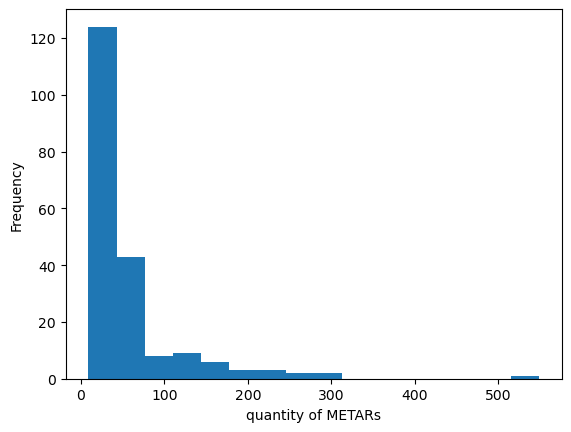

In [41]:
ax: plt.Axes = pd.DataFrame(dataset_units).plot.hist(bins=16, legend=False)
ax.set_xlabel('quantity of METARs')

In [42]:
total_quantity = sum([entry.quantity for entry in dataset_units])
print(f'In total, {total_quantity} units of data are to be distributed for the dataset')

quantity_per_state: Dict[str, int] = {}
for state in target_states:
    quantity_per_state[state] = sum([entry.quantity for entry in dataset_units_per_state[state]])
    print(f'{state} has {quantity_per_state[state]} units of data')

In total, 12749 units of data are to be distributed for the dataset
California has 3224 units of data
Montana has 920 units of data
Washington has 1815 units of data
Florida has 1942 units of data
Texas has 4848 units of data


In [43]:
@dataclass
class DatasetSplit:
    training: float
    validation: float
    test: float

    def __init__(self, training: float, validation: float, test: float) -> None:
        if not math.isclose(training + validation + test, 1.0):
            raise ValueError('DatasetSplit must sum to 1.0 (100 %)')
        self.training = training
        self.validation = validation
        self.test = test
    
    def getAbsoluteNumbers(self, total_quantity:int) -> Tuple[int, int, int]:
        test_abs        = int(math.ceil(total_quantity * self.test))
        validation_abs  = int(math.ceil(total_quantity * self.validation))
        training_abs    = total_quantity - test_abs - validation_abs
        return (training_abs, validation_abs, test_abs)

In [44]:
dataset_split = DatasetSplit(0.80, 0.10, 0.10)
num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
print(f'DatasetSplit target:'
      f'\nTraining:\t{num_training}\t[{dataset_split.training * 100.0:.2f} %]'
      f'\nValidation:\t{num_validation}\t[{dataset_split.validation * 100.0:.2f} %]'
      f'\nTest:\t\t{num_test}\t[{dataset_split.test * 100.0:.2f} %]')

DatasetSplit target:
Training:	10199	[80.00 %]
Validation:	1275	[10.00 %]
Test:		1275	[10.00 %]


In [45]:
for state in target_states:
    dataset_units_per_state[state].sort(reverse=True)

In [46]:
@dataclass
class Dataset:
    data: List[DatasetUnit]
    current_size: int
    target_size: int

    def add(self, unit:DatasetUnit):
        self.data += [unit]
        self.current_size += unit.quantity

    def get_missing_quantity(self) -> int:
        return self.target_size - self.current_size
    
    def get_stations(self) -> Set[str]:
        return set.union(*[x.stations for x in self.data])
    
    @staticmethod
    def merge(a, b):
        return Dataset(a.data + b.data, a.current_size + b.current_size, a.target_size + b.target_size)

In [47]:
def greedy_partition(split:DatasetSplit, total_quantity:int, data:List[DatasetUnit]):
    num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
    training    = Dataset([], 0, num_training)
    validation  = Dataset([], 0, num_validation)
    test        = Dataset([], 0, num_test)
    for unit in data:
        # Get the dataset that is missing the most data
        next_dataset = max([
            (training.get_missing_quantity(),      training),
            (validation.get_missing_quantity(),  validation),
            (test.get_missing_quantity(),              test)
        ], key=lambda x: x[0])[1]
        next_dataset.add(unit)
    return (training, validation, test)

In [48]:
training    : Optional[Dataset] = None
validation  : Optional[Dataset] = None
test        : Optional[Dataset] = None
for state in target_states:
      training_subset, validation_subset, test_subset = \
            greedy_partition(dataset_split, quantity_per_state[state], dataset_units_per_state[state])
      if training is None:
            training = training_subset
      else:
            training = Dataset.merge(training, training_subset)
      if validation is None:
            validation = validation_subset
      else:
            validation = Dataset.merge(validation, validation_subset)
      if test is None:
            test = test_subset
      else:
            test = Dataset.merge(test, test_subset)
print(f'DatasetSplit:'
      f'\nTraining:\t{training.current_size}\t[{float(training.current_size) / float(total_quantity) * 100.0:.2f} %]'
      f'\nValidation:\t{validation.current_size}\t[{float(validation.current_size) / float(total_quantity) * 100.0:.2f} %]'
      f'\nTest:\t\t{test.current_size}\t[{float(test.current_size) / float(total_quantity) * 100.0:.2f} %]')

DatasetSplit:
Training:	10194	[79.96 %]
Validation:	1269	[9.95 %]
Test:		1286	[10.09 %]


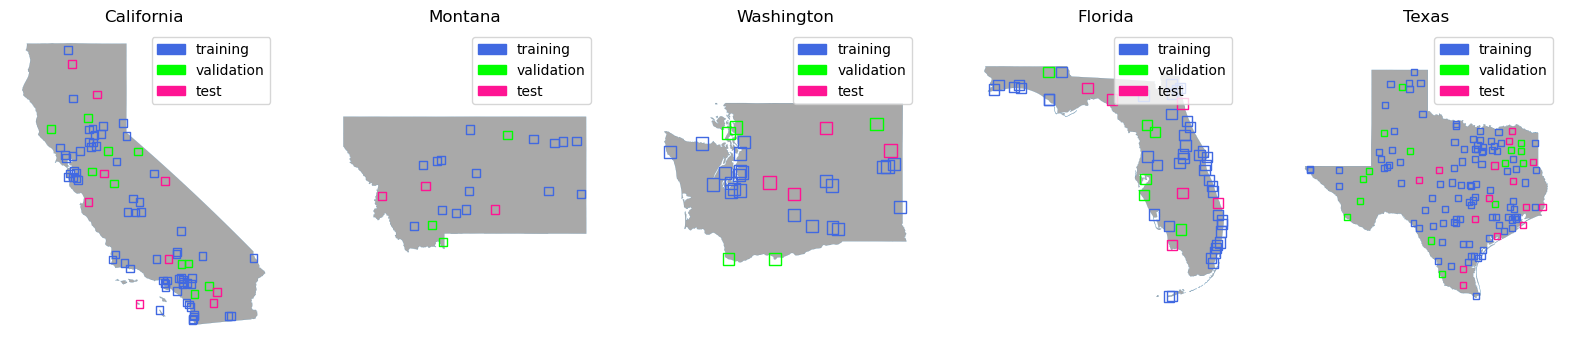

In [49]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    color_training = 'royalblue'
    color_validation = 'lime'
    color_test = 'deeppink'

    patch_training = mpatches.Patch(color=color_training, label='training')
    patch_validation = mpatches.Patch(color=color_validation, label='validation')
    patch_test = mpatches.Patch(color=color_test, label='test')

    selected_stations_metadata = remaining_stations_metadata.loc[list(training.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_training, legend=True
    )

    selected_stations_metadata = remaining_stations_metadata.loc[list(validation.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_validation, legend=True
    )

    selected_stations_metadata = remaining_stations_metadata.loc[list(test.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_test, legend=True
    )

    ax.legend(handles=[patch_training, patch_validation, patch_test])

In [50]:
os.makedirs(dataset_dir, exist_ok=True)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [51]:
print(training.get_stations())

{'PNS', 'TKI', 'CNO', 'OLF', 'NKX', 'LBB', 'HWD', 'SBD', 'YKM', 'CRP', 'PSN', 'SNA', 'F45', 'TIX', 'SGR', 'ATA', 'RAS', 'PYX', 'MHR', 'BCT', 'GTF', 'PSC', 'ONT', 'BYY', 'HRT', 'HHR', 'COF', 'HDO', 'DLF', 'BHK', 'ELP', 'SSF', 'MKN', 'SMX', 'O32', 'PPA', 'HST', 'PAO', 'BRO', 'UVA', 'NRB', 'RAL', 'AWO', 'HOU', 'SFB', 'MYV', 'LUV', 'EED', 'NID', 'CPT', 'HWO', 'ELA', 'EPH', 'SFF', 'POC', 'STS', 'VBG', 'TYR', '1GM', 'NUQ', 'BMT', 'GDP', 'AUN', 'TPL', 'IPL', 'APC', 'F17', 'X26', 'ZPH', 'LWT', 'VIS', 'CQT', '1KM', 'TIW', 'VRB', 'IAH', 'OAK', 'ARM', 'SQL', '6S0', 'RKP', 'BEA', 'ODO', 'INJ', 'MLB', 'HAF', 'NXF', 'GOO', 'SHN', 'AFW', 'VPS', 'EFD', 'DFW', 'PLU', 'FPR', 'COT', 'BZN', 'LAX', 'EDC', 'HRX', 'RIV', 'RSW', '28J', 'SMO', 'NLC', 'OMN', 'SMF', 'FAT', 'NQI', 'JSO', 'TCM', 'GNC', 'SEP', 'BKV', 'ORL', 'HBV', 'NIP', 'VCB', 'MYF', 'GKY', 'UIL', 'NJK', 'CDS', 'RBL', 'EDW', '8T6', 'SBA', 'ISM', 'SIY', 'XMR', 'DTO', 'FIN', 'TOA', 'AXH', 'AJO', 'NGP', 'LNA', 'LRD', 'LFK', 'JAX', 'MMH', 'DLN', 'PBI'

In [52]:
all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
all_band_resolutions_meters = [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20]
bands_metadata = pd.DataFrame([all_bands, all_band_resolutions_meters]).T
bands_metadata.columns = ['band', 'resolution [m]']
bands_metadata.set_index('band', inplace=True)
bands_metadata

,resolution [m]
band,
B1,60
B2,10
B3,10
B4,10
B5,20
B6,20
B7,20
B8,10
B8A,20


In [53]:
bands_subset = ['B4', 'B3', 'B2', 'B11']
assert pd.Series(bands_subset).isin(bands_metadata.index).all(), 'Some bands are invalid!'

In [54]:
def get_features_img_paths(station:str, product_id:str, bands:List[str]) -> Dict[str, str]:
    features_dir = state_dirs.loc[station_metadata.loc[station, 'state'], 'features']
    return {band: os.path.join(features_dir, product_id, band, f'{station}.jp2') for band in bands}

def get_dataset_path(target_dir:str, station:str, product_id:str) -> str:
    return os.path.join(target_dir, station, f'{product_id}.tif')

def map_files_to_dataset_paths(dataset:Dataset, target_dir:str) -> List[Tuple[Dict[str, str], str]]:
    data_subset = labels[(labels['station'].isin(dataset.get_stations()))]
    return data_subset.apply(
        lambda x: (get_features_img_paths(x.station, x.product_id, bands_subset),
                   get_dataset_path(target_dir, x.station, x.product_id)), axis=1)

In [55]:
dataset_file_mappings = [mapping for sublist in [
    map_files_to_dataset_paths(training, training_dir),
    map_files_to_dataset_paths(validation, validation_dir),
    map_files_to_dataset_paths(test, test_dir)
] for mapping in sublist]

In [56]:
dataset_file_mappings

[({'B4': 'data\\queries\\California\\features\\00065e39-660f-4b17-a4ff-d528b87cef65\\B4\\MMH.jp2',
   'B3': 'data\\queries\\California\\features\\00065e39-660f-4b17-a4ff-d528b87cef65\\B3\\MMH.jp2',
   'B2': 'data\\queries\\California\\features\\00065e39-660f-4b17-a4ff-d528b87cef65\\B2\\MMH.jp2',
   'B11': 'data\\queries\\California\\features\\00065e39-660f-4b17-a4ff-d528b87cef65\\B11\\MMH.jp2'},
  'data\\dataset_16km_300_ndsi\\training\\MMH\\00065e39-660f-4b17-a4ff-d528b87cef65.tif'),
 ({'B4': 'data\\queries\\California\\features\\004885ef-ae75-4aca-917a-4218687d4536\\B4\\MCC.jp2',
   'B3': 'data\\queries\\California\\features\\004885ef-ae75-4aca-917a-4218687d4536\\B3\\MCC.jp2',
   'B2': 'data\\queries\\California\\features\\004885ef-ae75-4aca-917a-4218687d4536\\B2\\MCC.jp2',
   'B11': 'data\\queries\\California\\features\\004885ef-ae75-4aca-917a-4218687d4536\\B11\\MCC.jp2'},
  'data\\dataset_16km_300_ndsi\\training\\MCC\\004885ef-ae75-4aca-917a-4218687d4536.tif'),
 ({'B4': 'data\\quer

In [57]:
from rasterio.enums import Resampling

def transform_image(paths_from:Dict[str, str], img_size:int, get_simple_rgb:bool=False):
    # Load and rescale images, then convert to numpy
    images: Dict[str, np.ndarray] = {}
    for band, path in paths_from.items():
        image: rasterio.DatasetReader = rasterio.open(path)
        image_array = image.read(1, out_shape=(img_size, img_size), resampling=Resampling.cubic).astype(np.float32) / 10000
        profile = image.profile
        image.close()
        images[band] = image_array
    
    # Run calculations on base image-bands
    images_combined: Dict[str, np.ndarray] = {}
    if get_simple_rgb:
        images_combined['R'] = images['B4']
        images_combined['G'] = images['B3']
        images_combined['B'] = images['B2']
    else:
        index: np.ndarray = (images['B3'] - images['B11']) / (images['B3'] + images['B11'])
        index = index.clip(0.0, 1.0)
        images_combined['R'] = images['B4'] * (1.0 - index)
        images_combined['G'] = images['B3'] * (1.0 - index)
        images_combined['B'] = images['B2'] * (1.0 - index)

    # Stack images into final image
    image_tensors_stacked = np.stack(list(images_combined.values()), axis=0)
    image_tensors_stacked = np.nan_to_num(image_tensors_stacked)
    if np.isnan(image_tensors_stacked).flatten().any():
        raise RuntimeError('Detected NaN values in image!')
    profile['count'] = image_tensors_stacked.shape[0]
    profile['transform'] = profile['transform'] * profile['transform'].scale(
        (profile['width'] / image_tensors_stacked.shape[2]),
        (profile['height'] / image_tensors_stacked.shape[1])
    )
    profile['height'] = image_tensors_stacked.shape[1]
    profile['width'] = image_tensors_stacked.shape[2]
    profile['dtype'] = image_tensors_stacked.dtype
    if 'tiled' in profile:
        profile.pop('tiled')
    if 'blockxsize' in profile:
        profile.pop('blockxsize')
        profile.pop('blockysize')
    profile['driver'] = 'GTiff'
    return image_tensors_stacked, profile

In [58]:
dateset_index = 58

In [59]:
dateset_index

58

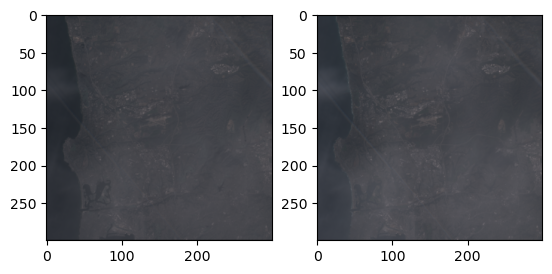

In [60]:
fig, axs = plt.subplots(ncols=2)
plot.show(transform_image(dataset_file_mappings[dateset_index][0], image_size)[0], ax=axs[0])
plot.show(transform_image(dataset_file_mappings[dateset_index][0], image_size, get_simple_rgb=True)[0], ax=axs[1])
dateset_index += 1

In [61]:
for paths_from, path_to in tqdm(dataset_file_mappings):
    os.makedirs(os.path.dirname(path_to), exist_ok=True)
    if not os.path.exists(path_to):
        image_out, profile_out = transform_image(paths_from, image_size, get_simple_rgb=False)
        with rasterio.open(path_to, 'w', **profile_out) as dst:
            dst.write(image_out)

 20%|██        | 2605/12749 [02:35<11:03, 15.28it/s]C:\Users\erikw\AppData\Local\Temp\ipykernel_2516\1381667800.py:20: RuntimeWarning: invalid value encountered in divide
  index: np.ndarray = (images['B3'] - images['B11']) / (images['B3'] + images['B11'])
100%|██████████| 12749/12749 [12:33<00:00, 16.93it/s]


In [62]:
def create_dataset_labels(dataset:Dataset):
    return labels[labels['station'].isin(dataset.get_stations())].copy()

In [63]:
training_labels = create_dataset_labels(training)
validation_labels = create_dataset_labels(validation)
test_labels = create_dataset_labels(test)

<Axes: title={'center': 'Test'}, ylabel='Frequency'>

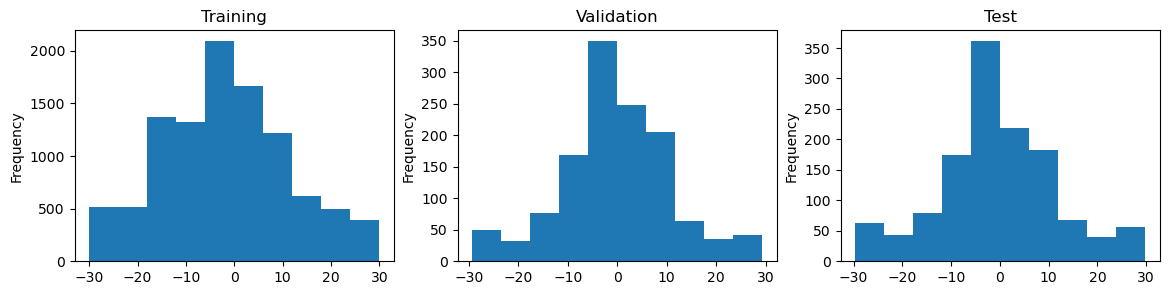

In [64]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[0], title='Training')
validation_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[1], title='Validation')
test_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[2], title='Test')

In [65]:
def print_time_dist(data:pd.DataFrame, name:str):
    series = data['timedelta [minutes]']
    print(f'{name}\tmean offset: {series.mean():.1f} minutes,\tvariance: {series.var():.1f}')

print_time_dist(training_labels, 'Training')
print_time_dist(validation_labels, 'Validation')
print_time_dist(test_labels, 'Test\t')

Training	mean offset: -1.6 minutes,	variance: 171.4
Validation	mean offset: -0.2 minutes,	variance: 119.5
Test		mean offset: -0.8 minutes,	variance: 142.4


In [66]:
training_labels.shape[0]

10194

In [67]:
training_label_counts = pd.Series(dict(Counter(training_labels['max cloud cover'])))
validation_label_counts = pd.Series(dict(Counter(validation_labels['max cloud cover'])))
test_label_counts = pd.Series(dict(Counter(test_labels['max cloud cover'])))

<Axes: title={'center': 'Test'}>

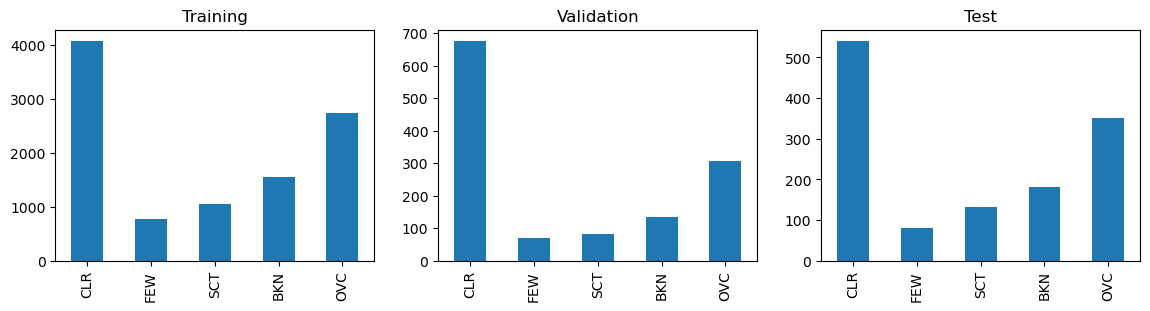

In [68]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[0], title='Training')
validation_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[1], title='Validation')
test_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[2], title='Test')

In [69]:
training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index=False)
validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index=False)
test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index=False)

In [70]:
def get_label_weights(label_counts:pd.DataFrame):
    label_weights = pd.DataFrame(label_counts.sum() / label_counts, columns=['weight'])
    # label_weights = pd.DataFrame(label_counts.sum() / pow(label_counts, 1.1), columns=['weight'])
    # label_weights = pd.DataFrame(1.0 - np.sqrt(label_counts / label_counts.sum()), columns=['weight'])
    # label_weights = label_weights / label_weights.sum()
    label_weights.index.set_names('label', inplace=True)
    return label_weights.loc[cloud_covers_order]

training_weights = get_label_weights(training_label_counts)
training_weights

,weight
label,
CLR,2.495471
FEW,13.238961
SCT,9.680912
BKN,6.572534
OVC,3.727239


In [71]:
training_label_counts.loc[cloud_covers_order] * training_weights.loc[cloud_covers_order]['weight']

label
CLR    10194.0
FEW    10194.0
SCT    10194.0
BKN    10194.0
OVC    10194.0
dtype: float64

In [72]:
training_weights.to_csv(os.path.join(dataset_dir, 'training_weights.csv'))

In [73]:
bands_metadata.loc[bands_subset].to_csv(os.path.join(dataset_dir, 'bands_metadata.csv'), index=True)

In [74]:
size = 0
for path, dirs, files in os.walk(dataset_dir):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)
byte_size_factor = int(math.floor(int(math.floor(math.log(size, 10))) + 1) / 3)
byte_size_name = 'B'
if byte_size_factor == 1:
    byte_size_name = 'KB'
if byte_size_factor == 2:
    byte_size_name = 'MB'
if byte_size_factor == 3:
    byte_size_name = 'GB'
print(f'Dataset size: {size / math.pow(1000, byte_size_factor):.1f} {byte_size_name}')

Dataset size: 13.8 GB
